# Collaborative filtering - memory based using cosine distance and kNN

Recommender systems are an integral part of many online systems. From e-commerce to online streaming platforms.
Recommender systems employ the past purchase patters on it's user to predict which other products they may in interested in and likey to purchase. Recommending the right products gives a significat advantage to the business. A major portion of the revenue is generated through recommendations.


**The Collaborative Filtering algorithm** is very popular in **online streaming platforms** and **e-commerse** sites where the customer interacts with each product (which can be a movie/ song or consumer products) by either liking/ disliking or giving a rating of sorts. User interaction is required.




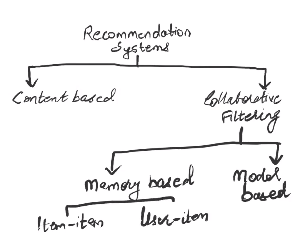

This notebook walks through the implementation of **collaborative filtering** using **memory based technique of distnce proximity** using **cosine distances** and **nearest neighbours**.

## Importing libraries and initial data checks

In [4]:
# import required libraries
import pandas as pd
import numpy as np

### About the data

This is a dataset related to over 2 Million customer reviews and ratings of Beauty related products sold on Amazon's website.

It contains:
- the unique UserId (Customer Identification),
- the product ASIN (Amazon's unique product identification code for each product),
- Ratings (ranging from 1-5 based on customer satisfaction) and
- the Timestamp of the rating (in UNIX time)

In [8]:
# raed the dataset
df = pd.read_csv('/ratings_Beauty.csv')
df.shape

(25735, 3)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# check the first 5 rows
df.head(20)

,HC,5.0,1401321600
A1BMHNKHJ7ZPJT,B004H04QHC,5.0,1354838400
A2CTCTZQX03OPO,B004H04QHC,5.0,1350518400
ASVHZCEVYUJ3H,B004H04QHC,5.0,1344729600
A1W2QH1LI4YQR4,B004H04QHC,5.0,1400284800
A2KH6WLU5SH3K,B004H04QHC,5.0,1350172800
A2VSZF2IYC0E70,B004H04QHC,5.0,1401753600
A150P8SU14C53N,B004H04QHC,5.0,1399593600
A35EHQ8O5F2M0W,B004H04QHC,5.0,1399334400
AW74TGO2XX0Q0,B004H04QHC,4.0,1393891200
A1G0QOZNBK26NW,B004H04QHC,5.0,1330560000


In [14]:
df.reset_index(inplace=True)

In [15]:
# check if there's unnecessary space in the column names
column_names = df.columns
print(column_names)

Index(['index', 'HC', '5.0', '1401321600'], dtype='object')


In [16]:
new_column_names = ["UserId","ProductId", "Rating", "Timestamp"]
df.columns = new_column_names

In [19]:
df.head(5)

,UserId,ProductId,Rating,Timestamp
0,A1BMHNKHJ7ZPJT,B004H04QHC,5.0,1354838400
1,A2CTCTZQX03OPO,B004H04QHC,5.0,1350518400
2,ASVHZCEVYUJ3H,B004H04QHC,5.0,1344729600
3,A1W2QH1LI4YQR4,B004H04QHC,5.0,1400284800
4,A2KH6WLU5SH3K,B004H04QHC,5.0,1350172800


Check if there are any duplicate values present

In [17]:
duplicates = df.duplicated(["UserId","ProductId", "Rating", "Timestamp"]).sum()
print(' Duplicate records: ',duplicates)

 Duplicate records:  0


See the number of unique values present

In [18]:
print('unique users:',len(df.UserId.unique()))
print('unique products:',len(df.ProductId.unique()))
print("total ratings: ",df.shape[0])


unique users: 24676
unique products: 3315
total ratings:  25735


Check for null values

In [20]:
df.isnull().any()

UserId       False
ProductId    False
Rating       False
Timestamp    False
dtype: bool

Number of rated products per user

In [21]:
products_user= df.groupby(by = "UserId")["Rating"].count().sort_values(ascending =False)
products_user.head()

UserId
A3KEZLJ59C1JVH    16
A3HSOV4FIC8B4X    14
A1F7YU6O5RU432     7
A1DAFWS98LQD2R     7
A1IREJVK1WBRXF     7
Name: Rating, dtype: int64

Number of ratings per product

In [22]:
product_rated = df.groupby(by = "ProductId")["Rating"].count().sort_values(ascending = False)
product_rated.head()


ProductId
B004INUWX0    1430
B004K3D0FK     418
B004ISU5V4     381
B004H85FTM     338
B004HFBC9W     322
Name: Rating, dtype: int64

Number of products rated by each user

In [23]:
rated_users=df.groupby("UserId")["ProductId"].count().sort_values(ascending=False)
print(rated_users)

UserId
A3KEZLJ59C1JVH    16
A3HSOV4FIC8B4X    14
A1F7YU6O5RU432     7
A1DAFWS98LQD2R     7
A1IREJVK1WBRXF     7
                  ..
A2AK8MB9VTXI1D     1
A2AJX3JCAWSB6Q     1
A2AJBEZ7VGCZEV     1
A2AJ133514ALE8     1
AZZZMSZI9LKE6      1
Name: ProductId, Length: 24676, dtype: int64


In [24]:
rated_products=df.groupby("ProductId")["UserId"].count().sort_values(ascending=False)
print(rated_products)

ProductId
B004INUWX0    1430
B004K3D0FK     418
B004ISU5V4     381
B004H85FTM     338
B004HFBC9W     322
              ... 
B004HITRJQ       1
B004KEKGN8       1
B004J5MPUU       1
B004KEKGLK       1
B004IWHIRO       1
Name: UserId, Length: 3315, dtype: int64


Number of products with some minimum ratings

In [25]:
print('Number of products with minimum of 5 reviews/ratings:',rated_products[rated_products>5].count())
print('Number of products with minimum of 4 reviews/ratings:',rated_products[rated_products>4].count())
print('Number of products with minimum of 3 reviews/ratings:',rated_products[rated_products>3].count())
print('Number of products with minimum of 2 reviews/ratings:',rated_products[rated_products>2].count())
print('Number of products with minimum of 1 reviews/ratings:',rated_products[rated_products>1].count())

Number of products with minimum of 5 reviews/ratings: 775
Number of products with minimum of 4 reviews/ratings: 907
Number of products with minimum of 3 reviews/ratings: 1102
Number of products with minimum of 2 reviews/ratings: 1402
Number of products with minimum of 1 reviews/ratings: 1966


## Visualizing the data

In [26]:
# plot the data
import plotly.graph_objects as go
index = ['Total size of records', "Number of unique users","Number of unique products"]
values =[len(df),len(df['UserId'].unique()),len(df['ProductId'].unique())]

plot = go.Figure([go.Bar(x=index, y=values,textposition='auto')])
plot.update_layout(title_text='Number of Users and Products w.r.to Total size of Data',
                    xaxis_title="Records",
                    yaxis_title="Total number of Records")

plot.show()


### The ratings given by users

In [27]:
print("Range of Ratings: ", df['Rating'].value_counts())
print(list(df['Rating'].value_counts()))

values = list(df['Rating'].value_counts())

plot = go.Figure([go.Bar(x = df['Rating'].value_counts().index, y = values,textposition='auto')])

plot.update_layout(title_text='Ratings given by user',
                    xaxis_title="Rating",
                    yaxis_title="Total number of Ratings")

plot.show()


Range of Ratings:  5.0    15881
4.0     3795
1.0     2347
3.0     2241
2.0     1471
Name: Rating, dtype: int64
[15881, 3795, 2347, 2241, 1471]


### Products which are most popular

In [28]:
print("Products with occurred the most: \n",df['ProductId'].value_counts().nlargest(5))

values = list(df['ProductId'].value_counts())


plot = go.Figure([go.Bar(x = df['ProductId'].value_counts().nlargest(5).index, y = values,textposition='auto')])

plot.update_layout(title_text='Most rated products',
                    xaxis_title="ProductID",
                    yaxis_title="Number of times occurred in the data")

plot.show()


Products with occurred the most: 
 B004INUWX0    1430
B004K3D0FK     418
B004ISU5V4     381
B004H85FTM     338
B004HFBC9W     322
Name: ProductId, dtype: int64


### Average rating given by each user


In [29]:
ratings_per_user = df.groupby('UserId')['Rating'].count().sort_values(ascending=False)
print("Average rating given by each user: ",ratings_per_user.head())

plot = go.Figure(data=[go.Histogram(x=ratings_per_user)])
plot.show()


Average rating given by each user:  UserId
A3KEZLJ59C1JVH    16
A3HSOV4FIC8B4X    14
A1F7YU6O5RU432     7
A1DAFWS98LQD2R     7
A1IREJVK1WBRXF     7
Name: Rating, dtype: int64


In [30]:
ratings_per_product = df.groupby('ProductId')['Rating'].count().sort_values(ascending=False)
# print("Average rating given by each user: ",ratings_per_user.head())

plot = go.Figure(data=[go.Histogram(x=ratings_per_product)])
plot.show(title_text='Number of ratings per product',
                    xaxis_title="Product",
                    yaxis_title="Number of ratings")

In [31]:
ratings_per_product = df.groupby('ProductId')['Rating'].count().sort_values(ascending=False)
# print("Average rating given by each user: ",ratings_per_user.head())

plot = go.Figure(data=[go.Histogram(x=ratings_per_product.nlargest(2000))])
plot.show(title_text='Number of ratings per product',
                    xaxis_title="Product",
                    yaxis_title="Number of ratings")

### Products with very less ratings


In [32]:

rating_of_products = df.groupby('ProductId')['Rating'].count()
# convert to make dataframe to analyse data
number_of_ratings_given = pd.DataFrame(rating_of_products)
print("Products with ratings given by users: \n",number_of_ratings_given.head())

less_than_ten = []
less_than_fifty_greater_than_ten = []
greater_than_fifty_less_than_hundred = []
greater_than_hundred = []
average_rating = []

for rating in number_of_ratings_given['Rating']:
    if rating <=10:
        less_than_ten.append(rating)
    if rating > 10 and rating <= 50:
        less_than_fifty_greater_than_ten.append(rating)
    if rating > 50 and rating <= 100:
        greater_than_fifty_less_than_hundred.append(rating)
    if rating > 100:
        greater_than_hundred.append(rating)

    average_rating.append(rating)

print("Ratings_count_less_than_ten: ", len(less_than_ten))
print("Ratings_count_greater_than_ten_less_than_fifty: ", len(less_than_fifty_greater_than_ten))
print("Ratings_count_greater_than_fifty_less_than_hundred: ", len(greater_than_fifty_less_than_hundred))
print("Ratings_count_greater_than_hundred: ", len(greater_than_hundred))
print("Average number of products rated by users: ", np.mean(average_rating))



Products with ratings given by users: 
             Rating
ProductId         
B004H04QHC      17
B004H04QP4       3
B004H07IVS       4
B004H07J80      10
B004H07J8U       1
Ratings_count_less_than_ten:  2850
Ratings_count_greater_than_ten_less_than_fifty:  385
Ratings_count_greater_than_fifty_less_than_hundred:  48
Ratings_count_greater_than_hundred:  32
Average number of products rated by users:  7.7631975867269984


In [33]:
x_values = ["Ratings_count_less_than_ten","Ratings_count_greater_than_ten_less_than_fifty",
           "Ratings_count_greater_than_fifty_less_than_hundred","Ratings_count_greater_than_hundred"]
y_values = [len(less_than_ten),len(less_than_fifty_greater_than_ten),len(greater_than_fifty_less_than_hundred),
            len(greater_than_hundred)]


plot = go.Figure([go.Bar(x = x_values, y = y_values, textposition='auto')])

plot.add_annotation(
        x=1,
        y=100000,
        xref="x",
        yref="y")

plot.update_layout(title_text='Ratings Count on Products',
                    xaxis_title="Ratings Range",
                    yaxis_title="Count of Rating")
plot.show()


In [35]:
# import the LabelEncoder class from the sklearn.preprocessing module for
# for converting categorical labels (strings or integers) into numeric labels
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()


### To convert alphanumeric data to numeric

In [36]:
dataset = df
dataset['user'] = label_encoder.fit_transform(df['UserId'])
dataset['product'] = label_encoder.fit_transform(df['ProductId'])
dataset.head()


,UserId,ProductId,Rating,Timestamp,user,product
0,A1BMHNKHJ7ZPJT,B004H04QHC,5.0,1354838400,2170,0
1,A2CTCTZQX03OPO,B004H04QHC,5.0,1350518400,8812,0
2,ASVHZCEVYUJ3H,B004H04QHC,5.0,1344729600,23370,0
3,A1W2QH1LI4YQR4,B004H04QHC,5.0,1400284800,5755,0
4,A2KH6WLU5SH3K,B004H04QHC,5.0,1350172800,10125,0


In [37]:

# average rating given by each user
average_rating = dataset.groupby(by="user", as_index=False)['Rating'].mean()
print("Average rating given by users: \n",average_rating.head())
print("----------------------------------------------------------\n")


# let's merge it with the dataset as we will be using that later
dataset = pd.merge(dataset, average_rating, on="user")
print("Modified dataset: \n", dataset.head())
print("----------------------------------------------------------\n")

# renaming columns
dataset = dataset.rename(columns={"Rating_x": "real_rating", "Rating_y": "average_rating"})
print("Dataset: \n", dataset.head())
print("----------------------------------------------------------\n")


Average rating given by users: 
    user  Rating
0     0     5.0
1     1     5.0
2     2     5.0
3     3     2.0
4     4     5.0
----------------------------------------------------------

Modified dataset: 
            UserId   ProductId  Rating_x   Timestamp   user  product  Rating_y
0  A1BMHNKHJ7ZPJT  B004H04QHC       5.0  1354838400   2170        0       5.0
1  A2CTCTZQX03OPO  B004H04QHC       5.0  1350518400   8812        0       5.0
2   ASVHZCEVYUJ3H  B004H04QHC       5.0  1344729600  23370        0       5.0
3  A1W2QH1LI4YQR4  B004H04QHC       5.0  1400284800   5755        0       5.0
4   A2KH6WLU5SH3K  B004H04QHC       5.0  1350172800  10125        0       5.0
----------------------------------------------------------

Dataset: 
            UserId   ProductId  real_rating   Timestamp   user  product  \
0  A1BMHNKHJ7ZPJT  B004H04QHC          5.0  1354838400   2170        0   
1  A2CTCTZQX03OPO  B004H04QHC          5.0  1350518400   8812        0   
2   ASVHZCEVYUJ3H  B004H04QHC 

Certain users tend to give higher ratings while others tend to gibve lower ratings. To negate this bias, we normalise the ratings given by the users.

In [38]:
dataset['normalized_rating'] = dataset['real_rating'] - dataset['average_rating']
print("Data with adjusted rating: \n", dataset.head())


Data with adjusted rating: 
            UserId   ProductId  real_rating   Timestamp   user  product  \
0  A1BMHNKHJ7ZPJT  B004H04QHC          5.0  1354838400   2170        0   
1  A2CTCTZQX03OPO  B004H04QHC          5.0  1350518400   8812        0   
2   ASVHZCEVYUJ3H  B004H04QHC          5.0  1344729600  23370        0   
3  A1W2QH1LI4YQR4  B004H04QHC          5.0  1400284800   5755        0   
4   A2KH6WLU5SH3K  B004H04QHC          5.0  1350172800  10125        0   

   average_rating  normalized_rating  
0             5.0                0.0  
1             5.0                0.0  
2             5.0                0.0  
3             5.0                0.0  
4             5.0                0.0  


# Cosine Similarity

We use a distance based metric - cosine similarity to identify similar users. It is important first, to remove products that have very low number of ratings.

## Filter based on number of ratings available

In [39]:
rating_of_product = dataset.groupby('product')['real_rating'].count() # apply groupby
ratings_of_products_df = pd.DataFrame(rating_of_product)
print("Real ratings:\n",ratings_of_products_df.head()) # check for real rating for products


Real ratings:
          real_rating
product             
0                 17
1                  3
2                  4
3                 10
4                  1


In [40]:
filtered_ratings_per_product = ratings_of_products_df[ratings_of_products_df.real_rating >= 200]
print(filtered_ratings_per_product.head())
print(filtered_ratings_per_product.shape)

         real_rating
product             
125              338
224              322
460              235
1134             229
1136            1430
(12, 1)


In [41]:
# build a list of products to keep
popular_products = filtered_ratings_per_product.index.tolist()
print("Popular product count which have ratings over average rating count: ",len(popular_products))
print("--------------------------------------------------------------------------------")

filtered_ratings_data = dataset[dataset["product"].isin(popular_products)]
print("Filtered rated product in the dataset: \n",filtered_ratings_data.head())
print("---------------------------------------------------------------------------------")

print("The size of dataset has changed from ", len(dataset), " to ", len(filtered_ratings_data))
print("---------------------------------------------------------------------------------")

Popular product count which have ratings over average rating count:  12
--------------------------------------------------------------------------------
Filtered rated product in the dataset: 
              UserId   ProductId  real_rating   Timestamp   user  product  \
139  A3F4C09LC2C0DT  B004K3D0FK          2.0  1355184000  15698     2008   
223  A1JLLFINSMZM40  B004ITB3IW          5.0  1301616000   3601     1251   
459  A28TNJAT8D2W9Z  B004HFBC9W          4.0  1367712000   8117      224   
465  A1G10E7GBGFGPN  B004K3D0FK          3.0  1403395200   2965     2008   
504  A12F9NUFOJP9WC  B004HSO124          5.0  1401494400    463      460   

     average_rating  normalized_rating  
139             3.0               -1.0  
223             4.0                1.0  
459             4.5               -0.5  
465             4.0               -1.0  
504             5.0                0.0  
---------------------------------------------------------------------------------
The size of dataset h

## Creating the User-item matrix

In [42]:
similarity = pd.pivot_table(filtered_ratings_data,values='normalized_rating',index='UserId',columns='product')
similarity = similarity.fillna(0)
print("Updated Dataset: \n",similarity.head())

Updated Dataset: 
 product                125   224   460   1134  1136  1230  1251  2008  2166  \
UserId                                                                        
A00370223FX3K9TUF1QCL   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
A01524401TZMB1ZBFP908   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
A02732722N0H3B6J9VVXW   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
A038903116CWU9FL7GQ1I   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
A058255625HJL78EIFBA7   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

product                2556  2718  2730  
UserId                                   
A00370223FX3K9TUF1QCL   0.0   0.0   0.0  
A01524401TZMB1ZBFP908   0.0   0.0   0.0  
A02732722N0H3B6J9VVXW   0.0   0.0   0.0  
A038903116CWU9FL7GQ1I   0.0   0.0   0.0  
A058255625HJL78EIFBA7   0.0   0.0   0.0  


As you can see, this is a very sparse matrix

In [43]:
from sklearn.metrics.pairwise import cosine_similarity
import operator

In [44]:
selecting_users = list(similarity.index)
selecting_users = selecting_users[:100]
print("You can select users from the below list:\n",selecting_users)

You can select users from the below list:
 ['A00370223FX3K9TUF1QCL', 'A01524401TZMB1ZBFP908', 'A02732722N0H3B6J9VVXW', 'A038903116CWU9FL7GQ1I', 'A058255625HJL78EIFBA7', 'A0585254256P04GZEXIVC', 'A06044653363P2MNZ6HFH', 'A0607303OY583QCNDU9', 'A06403213IGUA8D8Q46VZ', 'A0647567NOSE5H95OBQ2', 'A1009VX6WY3WK3', 'A100DY9HFRXIKV', 'A102TLVPGCAG65', 'A103J32MHVQE9D', 'A104U9WCWGIQQY', 'A106NDUAD9KUGD', 'A107GDDEBNXZ53', 'A1083L2G8FHHLT', 'A1094FGUSFXS25', 'A109GJYY9MZMHR', 'A10FO6I83W11ZH', 'A10GNH4B861A7H', 'A10H321IONJ6F8', 'A10H63KUGJEPAJ', 'A10I8S0N6WSRS5', 'A10IWSWGVRWINE', 'A10K67M5ROMLWP', 'A10M1E7W1S2EMT', 'A10OET0P69XOXQ', 'A10ON7VRRR03TH', 'A10P75NOS41EYO', 'A10PFMVZIIV3AV', 'A10QM2A8LPUNWG', 'A10R1TAHF2P87T', 'A10VNRXRBC8OWG', 'A10W27F5CVZIE1', 'A10XCHJ4YK5HZL', 'A10ZW6ZLBEUR08', 'A1114U2PGZKUYZ', 'A1117GMDXJVQJW', 'A111X34HK42BWA', 'A115P6TM3CSJS8', 'A1161QC3GO9O94', 'A116O8Y1KIU1M', 'A116P2ZECUQDSX', 'A11870FA089HBV', 'A11A39RDYZISLN', 'A11AHM1DIQI24O', 'A11C069T90VEOO', 'A11CA0T

In [45]:
def getting_top_5_similar_users(user_id, similarity_table, k=5):
    '''

    :param user_id: the user we want to recommend
    :param similarity_table: the user-item matrix
    :return: Similar users to the user_id.
    '''

    # create a dataframe of just the current user
    user = similarity_table[similarity_table.index == user_id]
    # and a dataframe of all other users
    other_users = similarity_table[similarity_table.index != user_id]
    # calculate cosine similarity between user and each other user
    similarities = cosine_similarity(user, other_users)[0].tolist()

    indices = other_users.index.tolist()
    index_similarity = dict(zip(indices, similarities))

    # sort by similarity
    index_similarity_sorted = sorted(index_similarity.items(), key=operator.itemgetter(1))
    index_similarity_sorted.reverse()

    # take users
    top_users_similarities = index_similarity_sorted[:k]
    users = []
    for user in top_users_similarities:
        users.append(user[0])

    return users


In [ ]:
user_id = "A0010876CNE3ILIM9HV0"
similar_users = getting_top_5_similar_users(user_id, similarity)


In [ ]:
print("Top 5 similar users for user_id:",user_id," are: ",similar_users)

Top 5 similar users for user_id: A0010876CNE3ILIM9HV0  are:  ['AXNF1BLDR4P47', 'ARTHT19OB79VZ', 'ARQ9I3Y0VPB6N', 'AOXEXSN7M9ENJ', 'AN0AO97264HP4']


## Recommend products based on these top similar users

In [47]:
def getting_top_5_recommendations_based_on_users(user_id, similar_users, similarity_table, top_recommendations=5):
    '''

    :param user_id: user for whom we want to recommend
    :param similar_users: top 5 similar users
    :param similarity_table: the user-item matrix
    :param top_recommendations: no. of recommendations
    :return: top_5_recommendations
    '''

    # taking the data for similar users
    similar_user_products = dataset[dataset.UserId.isin(similar_users)]
#     print("Products used by other users: \n", similar_user_products.head())
#     print("---------------------------------------------------------------------------------")

    # getting all similar users
    similar_users = similarity_table[similarity_table.index.isin(similar_users)]

    #getting mean ratings given by users
    similar_users = similar_users.mean(axis=0)


    similar_users_df = pd.DataFrame(similar_users, columns=['mean'])

    # for the current user data
    user_df = similarity_table[similarity_table.index == user_id]


    # transpose it so its easier to filter
    user_df_transposed = user_df.transpose()


    # rename the column as 'rating'
    user_df_transposed.columns = ['rating']

    # rows with a 0 value.
    user_df_transposed = user_df_transposed[user_df_transposed['rating'] == 0]


    # generate a list of products the user has not used
    products_not_rated = user_df_transposed.index.tolist()
#     print("Products not used by target user: ", products_not_rated)
#     print("-------------------------------------------------------------------")

    # filter avg ratings of similar users for only products the current user has not rated
    similar_users_df_filtered = similar_users_df[similar_users_df.index.isin(products_not_rated)]

    # order the dataframe
    similar_users_df_ordered = similar_users_df_filtered.sort_values(by=['mean'], ascending=False)



    # take the top products
    top_products = similar_users_df_ordered.head(top_recommendations)
    top_products_indices = top_products.index.tolist()


    return top_products_indices



In [ ]:
print("Top 5 productID recommended are: ",
      getting_top_5_recommendations_based_on_users(user_id, similar_users, similarity))


In [ ]:
filtered_ratings_data.shape

(370511, 8)

In [ ]:
filtered_ratings_data.head()

,UserId,ProductId,real_rating,Timestamp,user,product,average_rating,normalized_rating
1,A39HTATAQ9V7YF,B002OVV7F0,3.0,1369699200,725046,81854,4.250000,-1.250000
18,AKJHHD5VEH7VG,B0000UTUVU,5.0,1232323200,1073169,2237,4.222222,0.777778
20,AKJHHD5VEH7VG,B000F8HWXU,5.0,1379721600,1073169,16510,4.222222,0.777778
45,AKJHHD5VEH7VG,B001LF4I8I,4.0,1232841600,1073169,65074,4.222222,-0.222222
47,AKJHHD5VEH7VG,B001OMI93S,5.0,1236643200,1073169,67333,4.222222,0.777778


In [ ]:
filtered_ratings_data[filtered_ratings_data['UserId']=="A0010876CNE3ILIM9HV0"]

,UserId,ProductId,real_rating,Timestamp,user,product,average_rating,normalized_rating
1160176,A0010876CNE3ILIM9HV0,B0055MYJ0U,1.0,1390521600,11,136012,2.5,-1.5


In [ ]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(filtered_ratings_data,test_size=0.2)

train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

In [ ]:
similarity = pd.pivot_table(train_data,values='normalized_rating',index='UserId',columns='product')
similarity = similarity.fillna(0)
print("Updated Dataset: \n",similarity.head())

Updated Dataset: 
 product                704     719     754     834     843     858     861     \
UserId                                                                          
A0010876CNE3ILIM9HV0      0.0     0.0     0.0     0.0     0.0     0.0     0.0   
A00126503SUWI86KZBMIN     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
A001573229XK5T8PI0OKA     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
A00203203EBR4E6BIUOKF     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
A00222842T0ZYI86C9LHU     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

product                873     944     981     ...  241604  242018  242048  \
UserId                                         ...                           
A0010876CNE3ILIM9HV0      0.0     0.0     0.0  ...     0.0     0.0     0.0   
A00126503SUWI86KZBMIN     0.0     0.0     0.0  ...     0.0     0.0     0.0   
A001573229XK5T8PI0OKA     0.0     0.0     0.0  ...     0.0     0.0     0.0   
A00203203EBR4E6BIUOKF  

In [ ]:
similarity.shape

(251587, 934)

In [ ]:
selecting_users = list(similarity.index)
selecting_users = selecting_users[:100]
print("You can select users from the below list:\n",selecting_users)

You can select users from the below list:
 ['A0010876CNE3ILIM9HV0', 'A00126503SUWI86KZBMIN', 'A001573229XK5T8PI0OKA', 'A00203203EBR4E6BIUOKF', 'A00222842T0ZYI86C9LHU', 'A00258542AL4VKETFLGIJ', 'A00259242VSCRZPGIWP0M', 'A00262022JQPXX5SXEVJR', 'A00275441WYR3489IKNAB', 'A00328401T70RFN4P1IT6', 'A00349462AOAVUUPEJNQZ', 'A00370223FX3K9TUF1QCL', 'A00407141VL6SB77B1GGG', 'A00414041RD0BXM6WK0GX', 'A00426443G4MEWS3K1XFA', 'A004511036AHSSV5O4SBY', 'A00454102SR84NOYTI0JS', 'A00463203QYS5I5X6MMXW', 'A00473363TJ8YSZ3YAGG9', 'A00491723IYKW5UI74AEX', 'A00612582Z6ZU2SDMRQ07', 'A00615442TZG6MHZXJOIZ', 'A006502622TE53S3J9W6H', 'A006680338J29DP17XALU', 'A00669491O55AKJ5QVH9L', 'A00679332RYOO5406ARSG', 'A00700212KB3K0MVESPIY', 'A0072717335KA6520NEMI', 'A00773851NXKGCZRY43PG', 'A0078719IR14X3NNUG0F', 'A00802872RVW2KLY6DAL0', 'A008374338GH2TUB0S8KP', 'A00852491YPMY2HLYZ52N', 'A0090635250IP002KMMIX', 'A00995931BE16NG4F52QC', 'A01026292DKV5RYUH42C9', 'A01032093UTJ2SF3EQFS1', 'A010407538LRAQYK3G2RZ', 'A011004

In [ ]:
user_id = "A02720223TDVZSWVZYFN7"
similar_users = getting_top_5_similar_users(user_id, similarity)

In [ ]:
print("Top 5 similar users for user_id:",user_id," are: ",similar_users)

Top 5 similar users for user_id: A02720223TDVZSWVZYFN7  are:  ['AZZZRS1YZ8HVP', 'AZZZLM1E5JJ8C', 'AZZYW4YOE1B6E', 'AZZWMH759YWOO', 'AZZWJ3LICUEKJ']


In [ ]:
print("Top 5 productID recommended are: ",
      getting_top_5_recommendations_based_on_users(user_id, similar_users, similarity))

Top 5 productID recommended are:  [30773, 27327, 704, 119742, 120416]


In [ ]:
test_data.shape

(74103, 8)

In [ ]:
len(test_data.user.unique())

70086

In [ ]:
test_data.UserId

816493      A8L3SY93WH6RE
1075684    A1G9HOER3Z33HN
19929      A20ETYDYHBS65I
823482     A2BZX4FT2MAQ3E
953423     A3F1QZZ8Q4K8UC
                ...      
491306     A25E8ERP6QDTQ9
410840      ANSWZO96P8CT8
1478895    A3345MYPQLZYJX
654127      AV4J839UXLQUA
823443     A1MC4GSVPJ8IW6
Name: UserId, Length: 74103, dtype: object

In [ ]:
test_data.head()

,UserId,ProductId,real_rating,Timestamp,user,product,average_rating,normalized_rating
816493,A8L3SY93WH6RE,B000TKH6G2,5.0,1359936000,967193,33868,4.285714,0.714286
1075684,A1G9HOER3Z33HN,B001CT0AGC,3.0,1403049600,145202,55791,3.000000,0.000000
19929,A20ETYDYHBS65I,B0029ERWH4,5.0,1357862400,324407,74759,4.962963,0.037037
823482,A2BZX4FT2MAQ3E,B009HULKLW,5.0,1391299200,426989,189437,5.000000,0.000000
953423,A3F1QZZ8Q4K8UC,B002WTC37U,5.0,1305849600,774386,86489,5.000000,0.000000


In [ ]:
def recommend_products_for_user(userId, similarity_matrix):
    similar_users = getting_top_5_similar_users(user_id, similarity_matrix)
#     print("Top 5 similar users for user_id:",user_id," are: ",similar_users)
    product_list = getting_top_5_recommendations_based_on_users(user_id, similar_users, similarity)
#     print("Top 5 productID recommended are: ", product_list)
    return product_list

In [ ]:
recommend_products_for_user("A2XVNI270N97GL", similarity)

[30773, 27327, 704, 119742, 120416]

### Conclusion

Recommender systems are a powerful technology that adds to a businesses value. Some business thrive on their recommender systems. It helps the business by creating more sales and it helps the end users find items they like.